In [1]:
import numpy as np
import torch
from torch import nn, utils

import matplotlib.pyplot as plt
import os
import wget

In [2]:
# download data
if not os.path.exists('prediction-challenge-01-data.npz'):
    url = 'https://git.imp.fu-berlin.de/yuxuac94/'\
    'deep-learning-examples/-/raw/master/01-Basic/'\
    'prediction-challenge-01-data.npz'
    wget.download(url, './prediction-challenge-01-data.npz')

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# meaning of dimension of our data
# 1st index: image id-number
# 2nd index: color channel
# 3 & 4th index: pixel value
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)
print(test_x.shape, test_x.dtype)

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


## Pre-processing

#### 1. Dataset Partition
Besides, since the test dataset has its labels invisible from us, in order to check the generalization of our model, we split the provided original training dataset(20000 images) into 2 parts: 
- the **training** dataset with 16,000 images, 
- the **validation** dataset with 4,000 images. 

#### 2. Format Compatibility and Batching
All numpy arrays are transformed into PyTorch tensors to get compatible with PyTorch methods. Finally `train_loader` is created using the PyTorch built-in `Dataloader` so as to iterate through the dataset and automatically batch them.

In [3]:
# split the data into train and valid set: 16000 vs. 4000
train_size = 18000
train_x, val_x = data_x[:train_size, ], data_x[train_size:, ]
train_y, val_y = data_y[:train_size, ], data_y[train_size:, ]

# transform all our numpy arrays into torch tensors
train_x, train_y, val_x, val_y, test_x = map(
    torch.tensor, (train_x, train_y, val_x, val_y, test_x))

In [4]:
# hyper-parameters
input_size = 784
hidden_size = 512
num_classes = 10
num_epochs = 50
batch_size = 512
learning_rate = 0.002
weight_decay = 0.01
dropout = 0

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# create datasets and dataloaders from our newly partitioned data
train_dataset = utils.data.TensorDataset(train_x,train_y)
train_loader = utils.data.DataLoader(dataset=train_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     pin_memory=True)

## Model

Our model is a  2-layer fully-connected neural network with ReLU as activation function. The structure can be illustrated as:
    
Input Layer(784 neurons)  =>  **FC Layer 1 + ReLU**  =>  Hidden Layer(`hidden_size` neurons)  =>  **FC Layer 2**  =>  Output Layer(10 neurons)

So a forward pass for a sample is:
(input)784 --(fc1)--> hidden_size --(relu)--> hidden_size --(fc2)--> (output)10

In [6]:
# build neural network of 2 fc-layers
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                 nn.Dropout(p=dropout))
        self.relu = nn.ReLU()
        self.fc2 = nn.Sequential(nn.Linear(hidden_size, output_size), 
                                 nn.Dropout(p=dropout))

    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [7]:
# set model, loss function and optimizer
model = NeuralNet(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size=num_classes,
                  dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

In [8]:
def accuracy(outputs, labels):
    assert outputs.size(0) == labels.size(0)

    _, pred = torch.max(outputs.data, 1)
    total = labels.size(0)
    hit = (pred == labels).sum()
    return 1.0 * hit / total

In [9]:
# train our model
best_val_acc = 0
for epoch in range(num_epochs):
    for images, labels in train_loader: 
        # each image of (28, 28) matric into a vector of length 764
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_acc = accuracy(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print the loss and accuracy for the last batch of this epoch
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
            epoch + 1, num_epochs, loss.item()))
    print('Training Accuracy: {:.3f}%'.format(100 * train_acc))

    # validate after each epoch
    with torch.no_grad():
        images, labels = val_x.to(device), val_y.to(device)
        outputs = model(images)
        val_acc = accuracy(outputs, labels)
        print('Validation Accuracy: {:.3f}%'.format(100 * val_acc))
        print('=' * 50)
        
        # save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if best_val_acc > 0.95:
                torch.save(model.state_dict(), './saved_model.ckpt')
            
print('Best Valid Accuracy: {:.3f}%'.format(100 * best_val_acc))

Epoch [1/50], Training Loss: 1.0245
Training Accuracy: 83.750%
Validation Accuracy: 87.600%
Epoch [2/50], Training Loss: 0.3284
Training Accuracy: 92.500%
Validation Accuracy: 91.300%
Epoch [3/50], Training Loss: 0.2600
Training Accuracy: 93.750%
Validation Accuracy: 93.100%
Epoch [4/50], Training Loss: 0.2189
Training Accuracy: 93.750%
Validation Accuracy: 94.050%
Epoch [5/50], Training Loss: 0.0352
Training Accuracy: 100.000%
Validation Accuracy: 94.100%
Epoch [6/50], Training Loss: 0.0586
Training Accuracy: 97.500%
Validation Accuracy: 94.700%
Epoch [7/50], Training Loss: 0.0423
Training Accuracy: 100.000%
Validation Accuracy: 95.600%
Epoch [8/50], Training Loss: 0.0223
Training Accuracy: 100.000%
Validation Accuracy: 95.400%
Epoch [9/50], Training Loss: 0.0493
Training Accuracy: 98.750%
Validation Accuracy: 95.200%
Epoch [10/50], Training Loss: 0.0401
Training Accuracy: 98.750%
Validation Accuracy: 95.650%
Epoch [11/50], Training Loss: 0.0246
Training Accuracy: 98.750%
Validation A

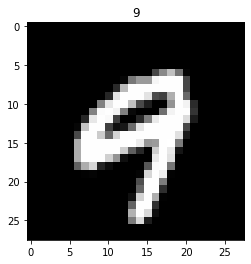

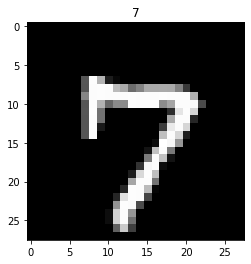

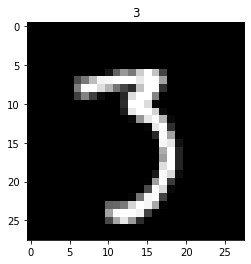

In [10]:
# load the saved model
saved_model = NeuralNet(input_size=input_size, 
                        hidden_size=hidden_size, 
                        output_size=num_classes).to(device)
saved_model.load_state_dict(torch.load('./saved_model.ckpt', 
                                       map_location=device))

# predict on test set with the saved model
with torch.no_grad():
    test_pred = saved_model(test_x.to(device))
    _, test_pred = torch.max(test_pred.data, 1)
    test_pred = test_pred.cpu().numpy()

# show some answers
for i in range(3):
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    plt.title(test_pred[i])
    plt.show()